# Brecha de género

En este documento queremos analizar la diferencia de sueldos entre hombres y mujeres, cuánto de ella podemos explicar con las respuestas de la encuesta, por ejemplo considerando si un grupo tiene mayor experiencia laboral que otro. También usar encuestas pasadas para analizar la tendencia.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
import scipy

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df.head()

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,NaN,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,NaN,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN


In [3]:
pd.DataFrame(df.keys())

,0
0,Me identifico
1,Tengo
2,Dónde estás trabajando
3,Años de experiencia
4,Años en la empresa actual
5,Años en el puesto actual
6,¿Gente a cargo?
7,Nivel de estudios alcanzado
8,Estado
9,Carrera


In [13]:
df['Me identifico'].value_counts()

Hombre    4922
Mujer      820
Otros       24
Name: Me identifico, dtype: int64

Lamentablemente hay muy pocas respuestas que no son hombre o mujer y no alcanzan los datos para sacar conclusiones, así que descartaré esos datos desde acá.

In [4]:
df = df[df['Me identifico'] != 'Otros']

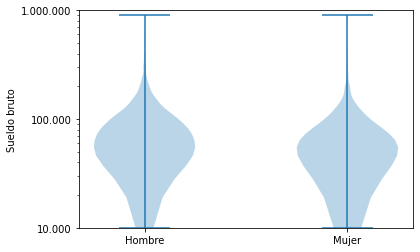

In [84]:
plt.ylabel('Sueldo bruto')
plt.yscale('log')
plt.ylim(10_000, 1_000_000)
plt.xticks([1, 2], ['Hombre', 'Mujer'])
plt.yticks([10_000, 100_000, 1_000_000], ['10.000', '100.000', '1.000.000'])
plt.violinplot([
    df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].values,
    df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].values,
]);


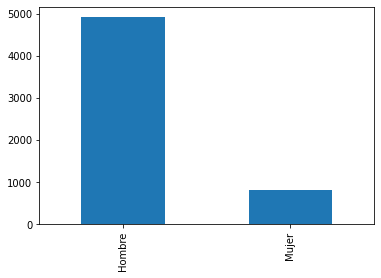

In [5]:
df['Me identifico'].value_counts().plot.bar();

In [6]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])

In [72]:
df[df['Me identifico'] == 'Mujer']['region'].value_counts()

AMBA         675
Pampa        110
Cuyo          14
NEA           12
NOA            5
Patagonia      4
Name: region, dtype: int64

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


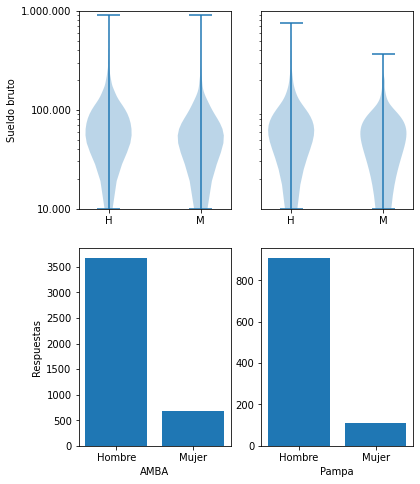

In [7]:
regions = ['AMBA', 'Pampa']
f, axs = plt.subplots(2, len(regions), figsize=(3*len(regions), 8))
for i, region in enumerate(regions):
    ax = plt.subplot(2, len(regions), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(regions), i+1+len(regions))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(region)
    s = df[df['region'] == region]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [8]:
degrees = df[df['Me identifico'] == 'Mujer']['Carrera'].value_counts()
degrees = degrees[degrees > 25].keys().to_list()

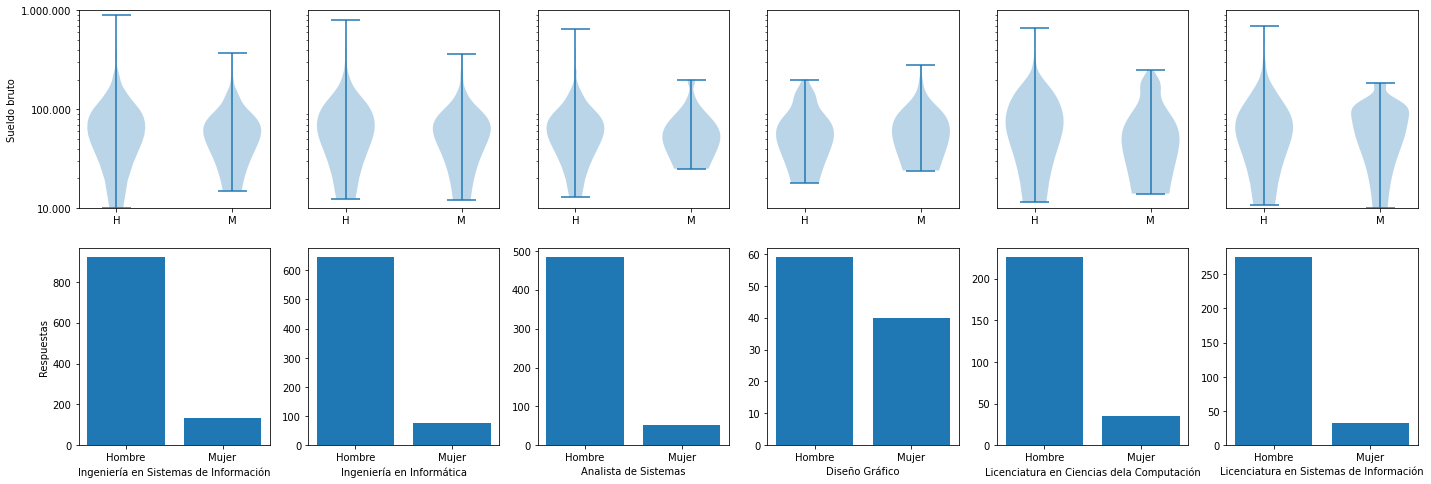

In [9]:
f, axs = plt.subplots(2, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(2, len(degrees), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(degrees), i+1+len(degrees))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(degree)
    s = df[df['Carrera'] == degree]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [10]:
df['log2(exp)'] = df['Años de experiencia'].apply(lambda x: math.floor(math.log(x+1, 2)))
df['log2(exp)'].value_counts()

3    1769
2    1487
4    1133
1     868
0     448
5      37
Name: log2(exp), dtype: int64

In [11]:
exps = sorted(df['log2(exp)'].unique())
exps

[0, 1, 2, 3, 4, 5]

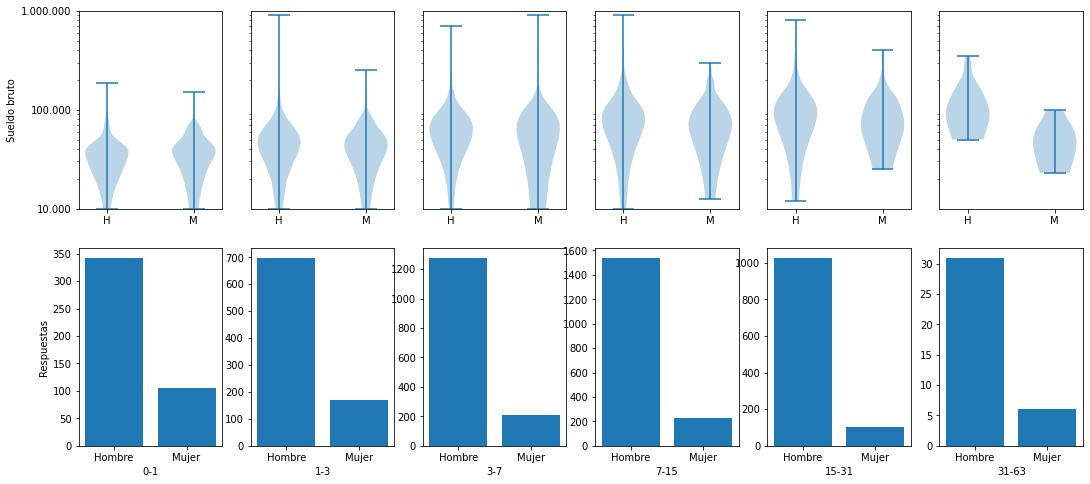

In [12]:
f, axs = plt.subplots(2, len(exps),figsize=(3*len(exps), 8))
for i, exp in enumerate(exps):
    ax = plt.subplot(2, len(exps), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(degrees), i+1+len(degrees))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    s = df[df['log2(exp)'] == exp]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [13]:
occupations = df[df['Me identifico'] == 'Mujer']['Trabajo de'].value_counts()
occupations = occupations[occupations > 25].keys().to_list()

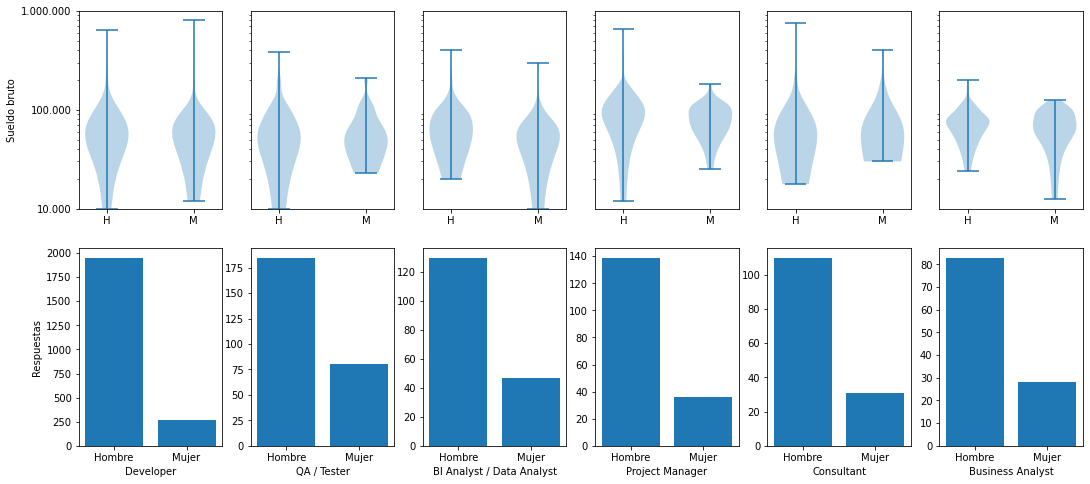

In [14]:
f, axs = plt.subplots(2, len(occupations),figsize=(3*len(occupations), 8))
for i, occupation in enumerate(occupations):
    ax = plt.subplot(2, len(occupations), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(occupations), i+1+len(occupations))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(occupation)
    s = df[df['Trabajo de'] == occupation]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

## Analizar la brecha de género

El sueldo depende de muchas cosas y es difícil de determinar. Si vemos una disparidad en los sueldos de por ejemplo BI, o de gente con más experiencia, es difícil establecer la causalidad para medirlos. Lo que podemos hacer es usar un modelo que establezca cuánto ganaría cada persona que respondió la encuesta al cambiarle su género, tomando el supuesto de que el modelo puede encontrar estas relaciones entre las distintas características.

In [15]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'provincia={regions_map[row["Dónde estás trabajando"]]}'
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1

valid_words = [word for word, c in counts.items() if c > 1]


def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [
        row['¿Gente a cargo?'],
        row['Años de experiencia'],
        row['Tengo'],
    ])
df_encoded = df.apply(encode_row, axis=1).astype(float)
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.65, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 8.0, 'n_estimators': 245, 'subsample': 0.8718795402022754}

In [16]:
cross_val_score(xgb.XGBRegressor(**best), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.6268904663868909

In [15]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.65, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 8.0, 'n_estimators': 245, 'subsample': 0.8718795402022754}
class Model:
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Estado',
                'Carrera',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v.lower().strip().replace(".", "")}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ] + [
            f'provincia={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 1]
        self.regressor_ = xgb.XGBRegressor(**best)
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [16]:
cross_val_score(Model(), df, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.6244472331349886

In [16]:
df['log(salary)'] = np.log(df['Salario mensual BRUTO (en tu moneda local)'])

In [103]:
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['log(salary)'])
    df.loc[df.index[test_index], 'e_log(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr_log(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h_log(salary)'] = df.apply(lambda row: row['e_log(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr_log(salary)'], axis=1)
df['e_m_log(salary)'] = df.apply(lambda row: row['e_log(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr_log(salary)'], axis=1)
df['e_g_diff(salary)'] = (np.exp(df['e_h_log(salary)']) - np.exp(df['e_m_log(salary)'])) / np.exp(df['e_h_log(salary)'])

In [19]:
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?",region,log2(exp),log(salary),e_log(salary),e_gr_log(salary),e_h_log(salary),e_m_log(salary),e_g_diff(salary)
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,"Comidas pagas / subvencionadas, Estacionamient...",NaN,NOA,4,10.621327,10.849187,10.759580,10.849187,10.759580,0.085710
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,Abono de celular y/o Internet,NaN,NOA,4,11.002100,11.273438,11.311114,11.311114,11.273438,0.036975
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN,NEA,3,12.100712,12.036552,12.015374,12.036552,12.015374,0.020956
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN,NEA,4,11.918391,11.942151,11.730498,11.942151,11.730498,0.190754
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,"Abono de celular y/o Internet, Comidas pagas /...",NaN,NEA,2,10.134599,10.744962,10.698336,10.744962,10.698336,0.045556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,Hombre,40,Tucumán,9.0,2.0,1.0,2,Universitario,Completado,Licenciatura en Informática,...,Ninguna de las anteriores,Ninguna,NOA,3,12.438968,10.871880,10.821172,10.871880,10.821172,0.049444
5977,Hombre,33,Tucumán,4.0,0.0,0.0,0,Terciario,Incompleto,Analista de Sistemas,...,"Capacitaciones y/o cursos, Clases de idiomas","Ninguna, todas son una mierda.",NOA,2,11.238489,10.973973,10.954437,10.973973,10.954437,0.019346
5978,Hombre,26,Tucumán,4.0,4.0,4.0,1,Terciario,En curso,Tecnicatura en Programación,...,"Capacitaciones y/o cursos, Clases de idiomas, ...",Everis globant sovos,NOA,2,10.594132,10.872184,10.878676,10.872184,10.878676,-0.006514
5979,Hombre,32,Tucumán,11.0,11.0,11.0,0,Terciario,Completado,Prof. Educación Tecnologica,...,"Comidas pagas / subvencionadas, Estacionamient...",NaN,NOA,3,10.668955,10.408251,10.379435,10.408251,10.379435,0.028405


In [20]:
df['e_g_diff(salary)'].mean()

0.0685942408242177

El modelo aprendiendo de los datos de la encuesta de sueldos concluyó que en promedio le tiene que pagar un 6.96% más a los hombres que a las mujeres, siendo el resto de las respuestas iguales.

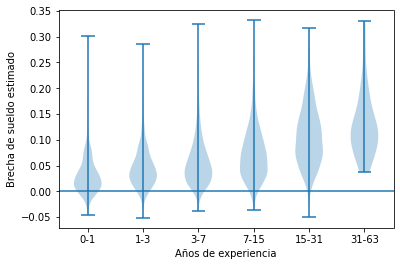

In [48]:
f, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xlabel('Años de experiencia')
ax.set_xticks([e+1 for e in exps])
ax.set_xticklabels([f'{2**exp-1}-{2**(1+exp)-1}' for exp in exps])
ax.axhline()
ax.violinplot([
    df[df['log2(exp)'] == exp]['e_g_diff(salary)'].values
    for exp in exps
]);

El modelo parece haber aprendido que mientras mayor es la experiencia de la persona, mayor debe ser la diferencia entre hombres y mujeres. Esto puede deberse a que los datos muestren un [techo de cristal](https://es.wikipedia.org/wiki/Techo_de_cristal).

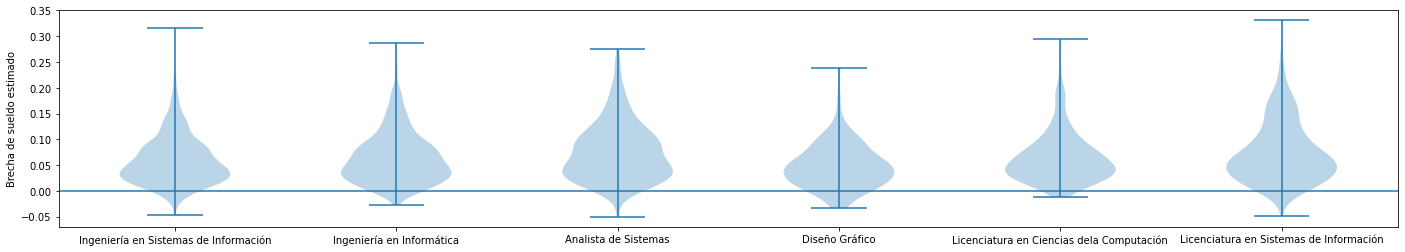

In [49]:
f, axs = plt.subplots(1, 1, figsize=(24, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xticks([e+1 for e, _ in enumerate(degrees)])
ax.set_xticklabels(degrees)
ax.axhline()
ax.violinplot([
    df[df['Carrera'] == degree]['e_g_diff(salary)'].values
    for degree in degrees
]);

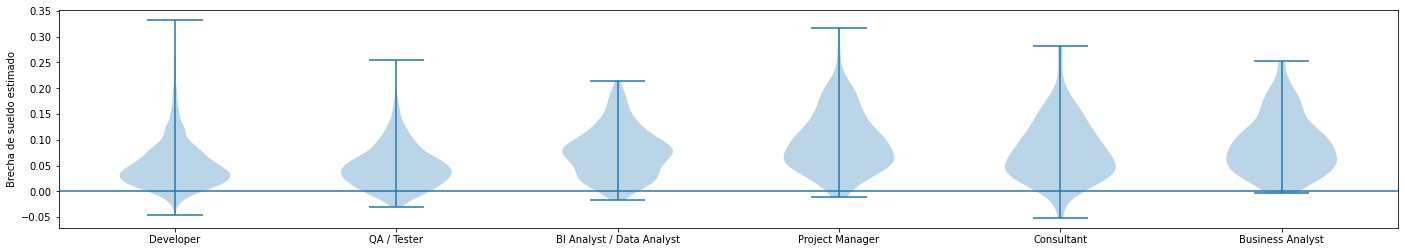

In [50]:
f, axs = plt.subplots(1, 1, figsize=(24, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xticks([e+1 for e, _ in enumerate(occupations)])
ax.set_xticklabels(occupations)
ax.axhline()
ax.violinplot([
    df[df['Trabajo de'] == occupation]['e_g_diff(salary)'].values
    for occupation in occupations
]);

## Modelo "gender-blind"

Creemos ahora un modelo que no considere explicitamente el género y veamos qué pasa con las estimaciones de sueldo de los hombres y de las mujeres comparadas con las estimaciones que lo toman en cuenta (del modelo "gender-aware").

In [18]:
df['Me identifico_copy'] = df['Me identifico']
df['Me identifico'] = ''
kf = KFold(n_splits=5, shuffle=True, random_state=99)
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['log(salary)'])
    df.loc[df.index[test_index], 'e_gb_log(salary)'] = model.predict(df.iloc[test_index])
df['Me identifico'] = df['Me identifico_copy']
df['e_gb_diff(salary)'] = (np.exp(df['e_log(salary)']) - np.exp(df['e_gb_log(salary)'])) / np.exp(df['e_log(salary)'])

In [56]:
df['e_gb_diff(salary)'].mean()

-0.0018576623446671745

In [54]:
df[(df['Me identifico'] == 'Hombre')]['e_gb_diff(salary)'].mean()

0.006464921792854056

In [55]:
df[(df['Me identifico'] == 'Mujer')]['e_gb_diff(salary)'].mean()

-0.051813466155495834

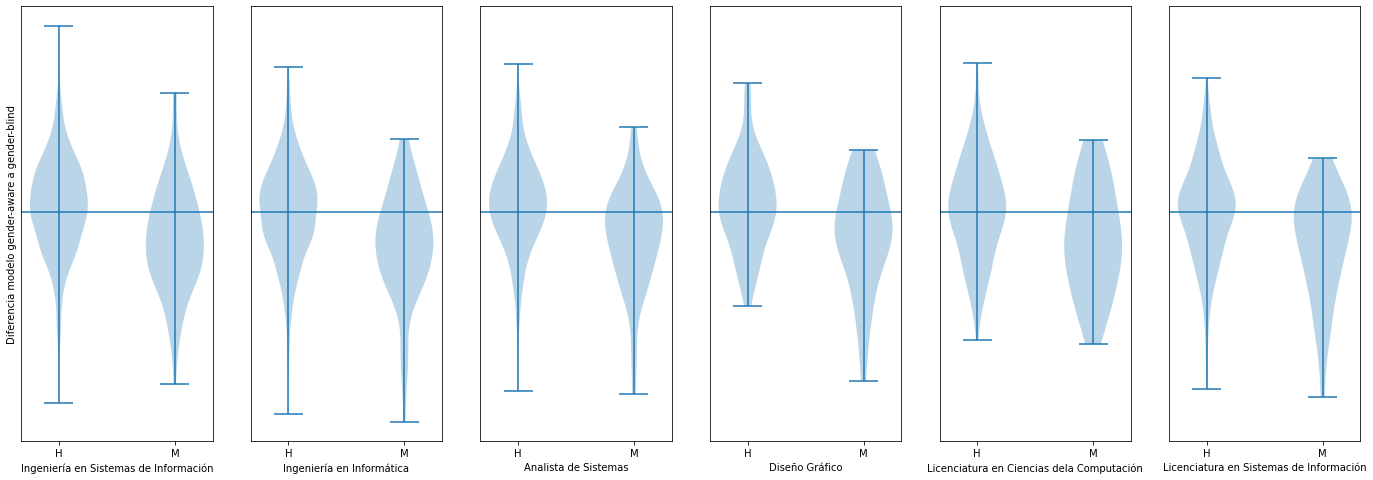

In [66]:
ax = None
f, axs = plt.subplots(1, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(degree)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['e_gb_diff(salary)'].values,
    ]);

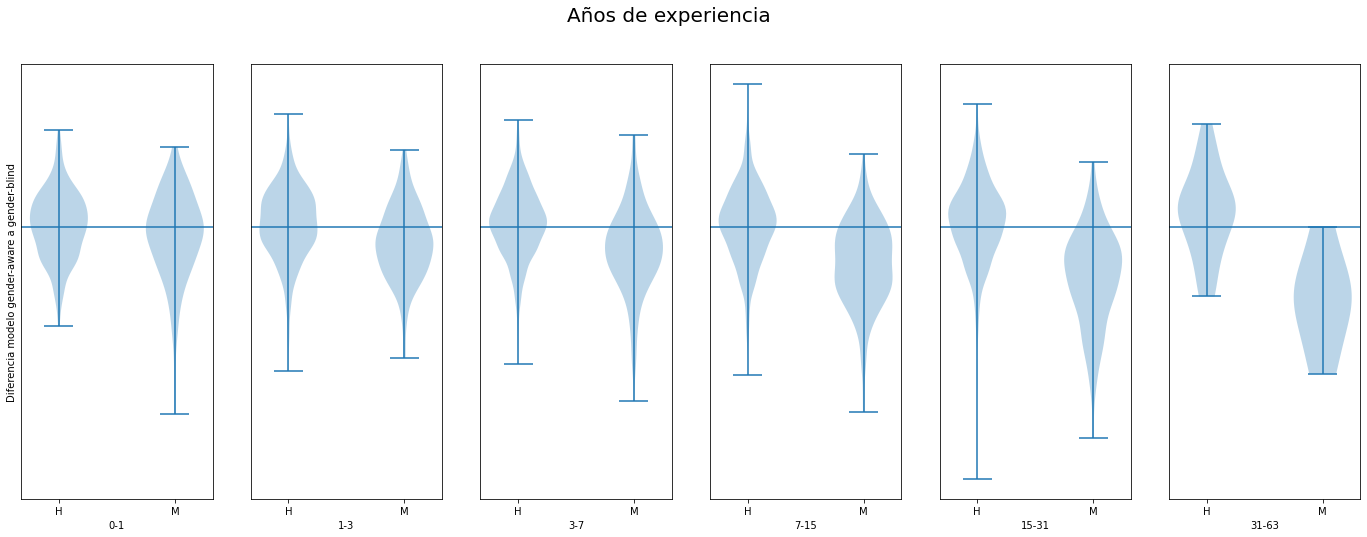

In [72]:
ax = None
f, axs = plt.subplots(2, len(exps),figsize=(4*len(exps), 8))
f.suptitle('Años de experiencia', fontsize=20)
for i, exp in enumerate(exps):
    ax = plt.subplot(1, len(exps), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(exp)
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['e_gb_diff(salary)'].values,
    ]);

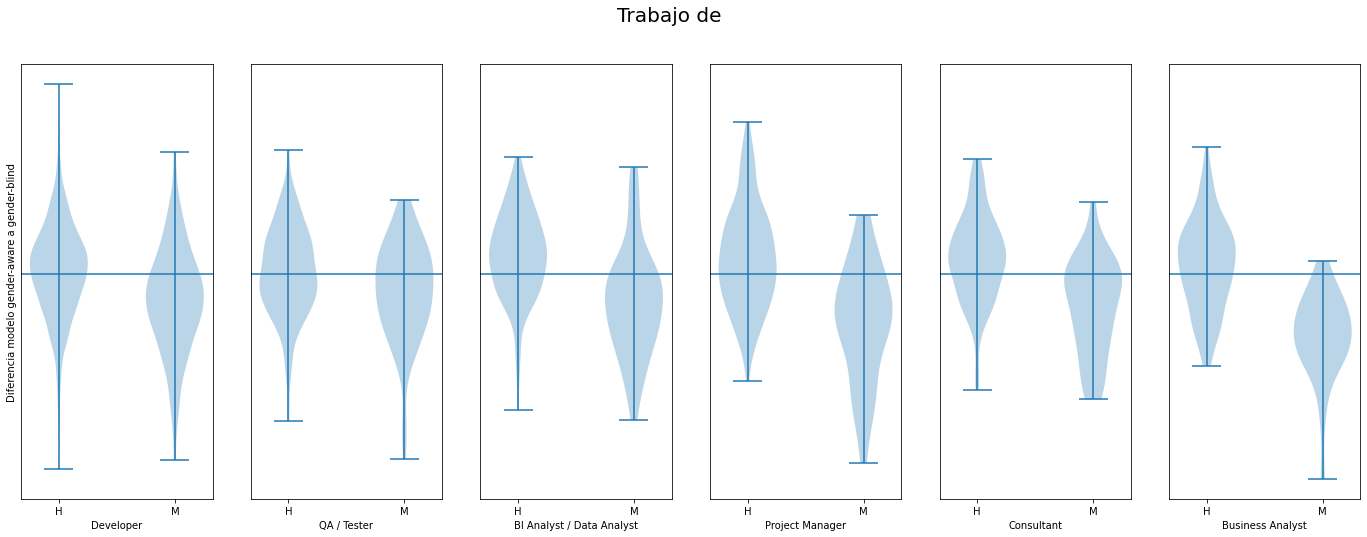

In [75]:
ax = None
f, axs = plt.subplots(1, len(occupations),figsize=(4*len(occupations), 8))
f.suptitle('Trabajo de', fontsize=20)
for i, occupation in enumerate(occupations):
    ax = plt.subplot(1, len(occupations), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(occupation)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['e_gb_diff(salary)'].values,
    ]);

Con el modelo que ignora el género vemos en todos los casos una caída del sueldo para las mujeres respecto al modelo que los considera.

### Explicar la diferencia

Vemos que el modelo aprendió que las mujeres por el mismo trabajo tienen que ganar menos, y no sólo eso, cuando le escondemos el género la diferencia se incrementa. Vamos a tratar de ver qué están viendo los modelos para ver qué características cobran más importancia al ser gender-blind. También podemos intentar comparar una versión de modelo sólo para hombres con una sólo de mujeres y ver en qué se fijan en cada caso.

In [19]:
models = {}
models['gender-aware'] = Model().fit(df, df['log(salary)'])
df['Me identifico'] = ''
models['gender-unaware'] = Model().fit(df, df['log(salary)'])
df['Me identifico'] = df['Me identifico_copy']

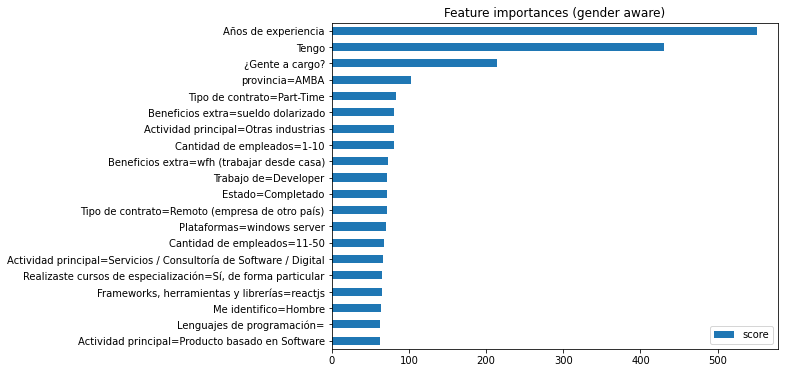

In [20]:
features = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True).tail(20)
data.plot(kind='barh', figsize=(8, 6), title='Feature importances (gender aware)');

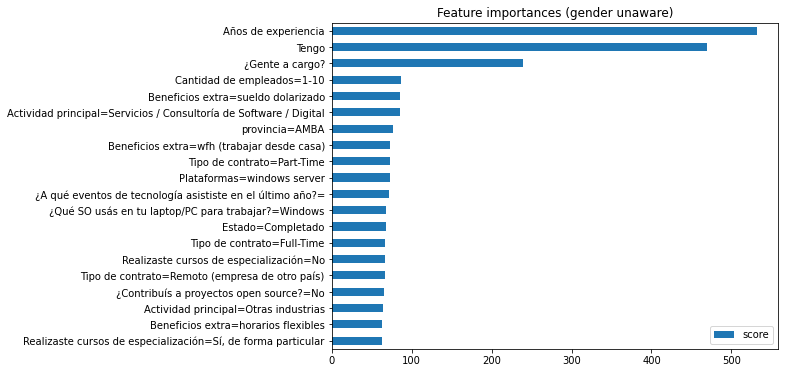

In [21]:
features = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True).tail(20)
data.plot(kind='barh', figsize=(8, 6), title='Feature importances (gender unaware)');

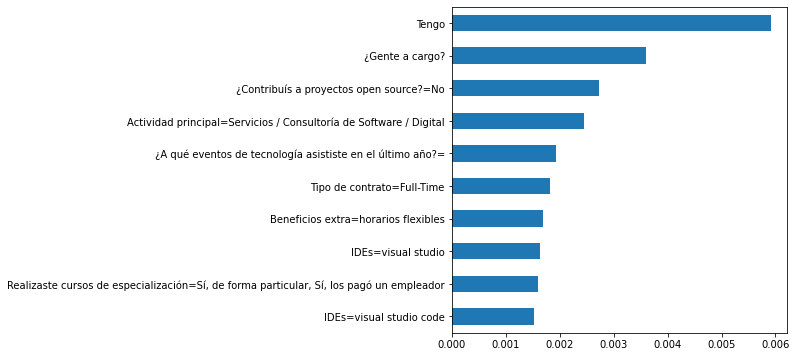

In [50]:
scores = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
sum_scores = sum(scores.values())
f = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important_aw = {f[int(k)]: v / sum_scores for k, v in scores.items()}

scores = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
sum_scores = sum(scores.values())
f = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important_unaw = {f[int(k)]: v / sum_scores for k, v in models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight').items()}

diff = pd.Series({k: (v - feature_important_aw.get(k, 0)) for k, v in feature_important_unaw.items()}).sort_values()
plt.subplots(1, 1, figsize=(6, 6))
diff.tail(10).plot.barh(ax=plt.subplot(1,1,1));

Cuando le sacamos género al modelo (unaware) la importancia se distribuye principalmente entre la edad y cuánta gente a cargo tiene la persona. Esto no nos dice si tienen una reacción positiva o negativa, pero vimos que el efecto en general es perjudicial para las mujeres. Podemos ver si estas dos variables son mayores en mujeres o en hombre para entender cómo el modelo nuevo las usa.

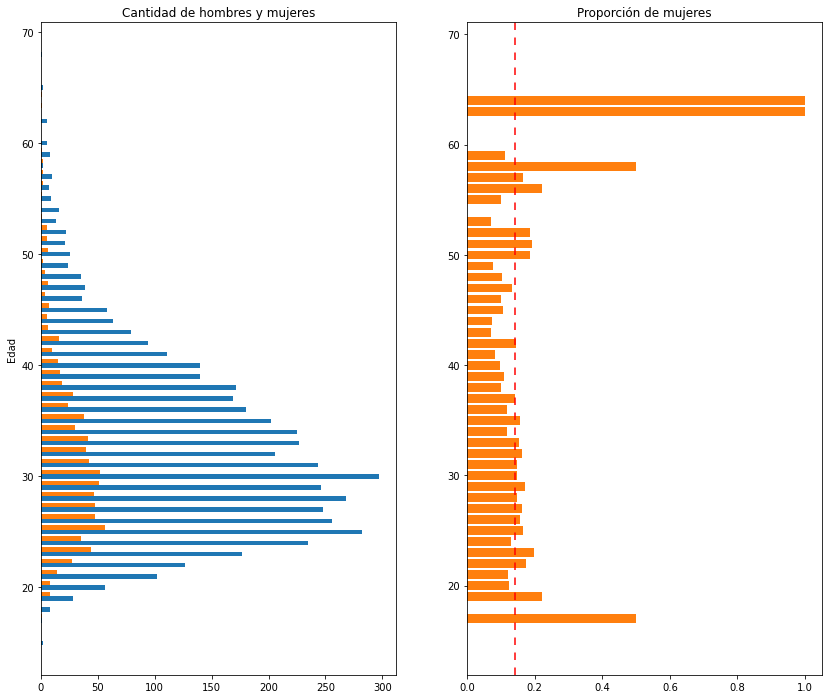

In [102]:
fig, _ = plt.subplots(1, 2, figsize=(14, 12))
ax = plt.subplot(1, 2, 1)
h = df[df['Me identifico'] == 'Hombre']['Tengo'].value_counts().sort_index()
m = df[df['Me identifico'] == 'Mujer']['Tengo'].value_counts().sort_index()
ax.barh(h.keys(), h.values, 0.4)
ax.barh(m.keys() + 0.4, m.values, 0.4);
ax.set_title('Cantidad de hombres y mujeres');
ax.set_ylabel('Edad')

ax = plt.subplot(1, 2, 2)
ax.barh(h.keys(), 0.0)
all_ages = sorted(set(h.keys()).union(set(m.keys())))
ax.barh(all_ages, [m.get(age, 0) / (h.get(age, 0) + m.get(age, 0)) for age in all_ages]);
ax.set_title('Proporción de mujeres');
ax.axvline(m.sum() / (h.sum() + m.sum()), color='red', dashes=(5,5));

La proporción de mujeres parece ser mayor en las edades de menor respuesta, pero no parece ser un [proxy](https://en.wikipedia.org/wiki/Proxy_(statistics)) claro.

## Cuán injustamente malo es el modelo

El modelo es el mejor modelo que pudimos lograr. Tiene un r2 de 0.6244, lo que quiere decir que no puede explicar un 38%. Todavía más podemos ver cómo si el error que comete es igual para hombres que para mujeres, y no sólo eso sino que ya vimos que las estimaciones para mujeres son un 7% inferiores que la de los hombres. Como en la muestra que tenemos hay menos mujeres que hombres (menos de un 15% del total) sabemos que el modelo priorizó la precisión de los hombres, por priorizar la precisión total.

In [140]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['log(salary)'], df[df['Me identifico'] == 'Hombre']['e_log(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['log(salary)'], df[df['Me identifico'] == 'Mujer']['e_log(salary)']))
print('r2 total', r2_score(df['log(salary)'], df['e_log(salary)']))

r2 hombre 0.6497353682097482
r2 mujer 0.5938675733625365
r2 total 0.6472607416865301


El error de predicción debería ser normal si el modelo no está sesgado. Veamos qué pasa por género.

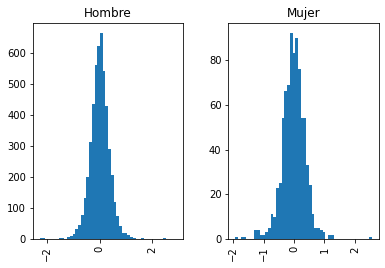

In [153]:
df['e_log(salary)_err'] = (df['log(salary)'] - df['e_log(salary)'])
df.hist(column='e_log(salary)_err', bins=50, by=df['Me identifico']);

In [158]:
(
scipy.stats.normaltest(df['e_log(salary)_err']),
scipy.stats.normaltest(df[df['Me identifico'] == 'Hombre']['e_log(salary)_err']),
scipy.stats.normaltest(df[df['Me identifico'] == 'Mujer']['e_log(salary)_err']),
)

(NormaltestResult(statistic=578.6293858538797, pvalue=2.2502218026423013e-126),
 NormaltestResult(statistic=507.45293142760556, pvalue=6.4268183893456245e-111),
 NormaltestResult(statistic=83.86968419958075, pvalue=6.136623467874115e-19))

In [164]:
print(f"total mean={np.mean(df['e_log(salary)_err'])}, var={np.var(df['e_log(salary)_err'])}")
print(f"hombres mean={np.mean(df[df['Me identifico'] == 'Hombre']['e_log(salary)_err'])}, var={np.var(df[df['Me identifico'] == 'Hombre']['e_log(salary)_err'])}")
print(f"mujeres mean={np.mean(df[df['Me identifico'] == 'Mujer']['e_log(salary)_err'])}, var={np.var(df[df['Me identifico'] == 'Mujer']['e_log(salary)_err'])}")

total mean=-0.0014167384629185577, var=0.14212103460803294
hombres mean=0.0009902607628686298, var=0.14081491763772624
mujeres mean=-0.015864604547460675, var=0.1497174052441435


Probemos aumentarle un 7% el sueldo a todas las mujeres y ver su efecto en la calidad de los resultados.

In [142]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['log(salary)'], df[df['Me identifico'] == 'Hombre']['e_log(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['log(salary)'], df[df['Me identifico'] == 'Mujer']['e_log(salary)'] + np.log(1.07)))
print('r2 total', r2_score(df['log(salary)'], df.apply(lambda row: row['e_log(salary)'] + (0.0 if row['Me identifico'] == 'Hombre' else np.log(1.07)), axis=1)))

r2 hombre 0.6497353682097482
r2 mujer 0.5756570446789209
r2 total 0.6448773434428572


El r2 baja, como era esperable, pero bastante poco. El r2 de mujeres también baja, más, y esto se explica porque le estamos agregando un error sistemático, haciendo [discriminación positiva](https://es.wikipedia.org/wiki/Discriminaci%C3%B3n_positiva).